#   <p style="text-align: center;">  FEDERATED LEARNING WITH PYTORCH </p>

In this notebook, we will implement a simple federated learning (FL) simulation, as described in [1].

Let us first start with defining the required parameters of a federated learning system and explain how they are utilized. 

In [1]:
#FL system parameters
num_users = 10
local_training_iters = 5
global_epochs = 15
fraction = 1


#model parameters
learning_rate = 0.01
momentum = 0.9 
batch_size = 32
test_batch_size =64

Now that we have the parameters, let us go over how an FL system operates. 

![FL](fl.png)
Fig.1 An FL system at any given iteration. Time index is omitted for convenience. 

In a traditional FL system, there is one central server and ```num_users``` ($N$) many users, each of whom has a local dataset (which are depicted by images in Fig. 1). The protocol runs for ```global_epochs``` many rounds. During each round $t$, each user $i\in [N]$ performs model training for ```local_training_iters``` rounds and computes the local model update $w_i^{t}$ via mini-batch gradient descent. Then, they send the freshly computed model parameters to the server. The server, in turn averages these model updates [<sup>1</sup>](#fn1) and computes the new global model: 
$$w^{t+1}=\frac{1}{N}\sum_{i\in[N]}w_i^{t}$$
Then, the server sends the new global model back to the users for the next round. This concludes one global round of FL. 



In the original protocol, the server randomly chooses only a subset (of size ```fraction``` $\times$ ```num_users```) of the users to perform local training and send in their model updates at each round. This ensures that communication and computation resources of the users are being leveraged effectively. With this in mind, the actual update rule for iteration $t$ is as follows: $$w^{t+1}=\frac{1}{N}\sum_{i\in\mathcal{S}^{t}}w_i^{t},$$ where $\mathcal{S}^{t}\subseteq[N]$ denotes the set of selected users at iteration $t$. Note that for ```fraction=1```, there is no client selection and the two updates rules are equivalent. 

There are many benefits of using FL for distributed learning:
1. Communication-efficiency: Since training occurs on the user-side, users do not share their datasets with any other party and they only share their model update with the server at the end of every ```local_training_iters``` iterations, instead of at the end of each iteration. Moreover, with the client selection property of FL, only a subset of the users participate at each global round. The combination of these three properties make FL a communication-efficient distributed learning paradigm. 
2. Computation-efficiency: The client selection property of FL also allows for a computation efficient distributed learning framework since even if one user does not participate the training process at a given round, the model is still being trained by the other users. Thus, a non-participating user still receives a global model without running no local training iteration.
3. Privacy: On-device learning architecture of FL allow data to remain on the user-side, which achieves a degree of privacy[<sup>2</sup>](#fn2) since the data is not observed by any other party. 
4. Customization: Federated learning protocols can easily be customized to meet specific needs because the protocol is very granular. 

Now that we have discussed the overall properties of an FL framework, let us get our hands dirty with some coding. For the sake of this notebook, we will not implement client selection and leave it to next notebook, where we will explore the most popular client selection strategies that are used with FL and implement them.


For this basic FL framework, we will implement 4 parts. 
1. Data handling
2. Model architecture
3. Local training loop
4. Model averaging


We first start with importing the required libraries. The code below used [2] as a starting point.

In [2]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import copy
from torch.utils.data.sampler import SubsetRandomSampler 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
import multiprocessing as mp

### DATA HANDLING
For this example, we will use the well-known Fashion MNIST [3] dataset. Fortunately, PyTorch provides built-in datasets and Fashion MNIST is one of them. To read more about which datasets are offered and how they can be used, read the <a href="https://pytorch.org/vision/stable/datasets.html">docs</a> and <a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">the tutorial</a>. With the piece of code below, we are able to download the dataset, normalize it and split it into train and test datasets with ease. 

In [3]:
# trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
dataset_train = datasets.FashionMNIST("../data/fashion/", train=True, download=True, transform=transform)
dataset_test = datasets.FashionMNIST("../data/fashion/", train=False, download=True, transform=transform)

/usr/local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


The next step is to split the training data into $N$ chunks and assign each user a chunk. For the purposes of this notebook, we will randomly divide the dataset into equally-sized chunks, which means that the dataset distribution of each user will be similar to of each other's, which we also term as independent identically distributed or IID for short.[<sup>3</sup>](#fn3)

We now randomly selected indices of the Fashion MNIST dataset that will belong to each user. Specifically, the indices of the Fashion MNIST training data that will be owned by user $i$ is stored in ```user_train_data_indices[i]```.

In [4]:
number_of_items_in_each_chunk = int(len(dataset_train)/num_users)
user_train_data_indices = {}
indices = np.arange(len(dataset_train))
for i in range(num_users):
    user_train_data_indices[i] = set(np.random.choice(indices, number_of_items_in_each_chunk,  replace = False))
    indices = list(set(indices) - user_train_data_indices[i])

Finally, we will set up the data loaders we will use to iterate over the data. A data loader is a useful tool, which is provided by PyTorch so we can easily split the data into batches for mini-batch training and iterate over the data points. I highly recommend reading the <a href="https://pytorch.org/docs/stable/data.html"> documentation</a>. 

We use the previously computed indices, which are stored in ```user_train_data_indices```, to create one ```SubsetRandomSampler``` per user to distribute the training dataset to users. Note that ```SubsetRandomSampler``` is a class that allows sampling from a dataset given some indices. We can then give the corresponding sampler as input to the train data loader of one user. Therefore, we create one training data loader and one sampler for each user since each user has their own dataset, and one test data loader for testing. 

In [5]:
test_dataloader = DataLoader(dataset_test, batch_size=test_batch_size)
train_dataloaders = []

for i in range(num_users):
    smplr = SubsetRandomSampler(list(user_train_data_indices[i]))
    train_dataloaders.append(DataLoader(dataset_train, batch_size=batch_size, shuffle=False, sampler = smplr))

At this point, each user has a random non-overalapping subset of the Fashion MNIST training dataset. 

### MODEL ARCHITECTURE

We will use a simple CNN architecture with two convolutional layers with 5x5 kernels and 10, 32 channels respectively. Then, we implement a fully connected layer with 512 units with the ReLU activation and finally an output layer with softmax activation. The network architecture is inspired from the CNN architecture that is used for training on MNIST in [1]. We use PyTorch for implementing and training the network. The <a href="https://pytorch.org/docs/stable/nn.html">docs</a> and <a href="https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html">the tutorial</a> on this subject are also very well-written. 

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 32, kernel_size=5)
        self.drop = nn.Dropout2d(p=0.2)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(512, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.drop(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

### LOCAL TRAINING LOOP

With the help of the data loaders that we defined, we define the training function that performs mini-batch training using its inputs: the dataset, the model parameters, the loss function for optimization and the optimizer of choice. 

In the next section of our code, each user will call this function ```local_training_iters``` times at each global round that they were selected to perform training.

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):

    num_batches = len(dataloader)
    train_loss = 0.0

    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/num_batches

### MODEL AVERAGING

We made it to the actual model averaging stage of federated learning! In this step, we will tie everything that we have done together and finish our FL implementation! Let us first configure the device that we will run the training on. As default, I set ```gpu_id=-1```, which means that the training will run on CPU. If you have a GPU, feel free to change ```gpu_id``` to the ID of the GPU that you will use!


We then initialize the model randomly, define some variables that we will use later and define the loss function as the cross entropy loss as we will perform a classification task. 

The model operations defined on this part are inspired from [this](https://github.com/pytorch/pytorch/blob/master/torch/optim/swa_utils.py) code, which I highly suggest you to go over. 

In [8]:
gpu_id = -1
device =  torch.device("cuda:{}".format(gpu_id)
            if torch.cuda.is_available() and gpu_id != -1
            else "cpu"
        )
local_model = CNN().to(device)
global_model = copy.deepcopy(local_model)
avg_model = copy.deepcopy(local_model)
loss_fn = nn.CrossEntropyLoss()
loss_train = []

## Below are some efficient and safe operations on tensors for operations on models ##

def copy_model(local_model, global_model):
    global_param = global_model.parameters()
    local_param = local_model.parameters()
    for local_t, global_t in zip(local_param, global_param):
        local_t.detach().copy_(global_t)

def zero_model(model):
    for param in model.parameters():
        param.detach().zero_()

def add_model(model_a, model_b):
    for a_t, b_t in zip(model_a.parameters(), model_b.parameters()):
        a_t.detach().add_(b_t)

def print_model(model):
    for param in model.parameters():
        print(f"params: {param}")

def div_model(model, divisor):
    for param in model.parameters():
        param.detach().mul_(1.0/divisor)


Here, each user calls the ```train_loop``` function with their local datasets for ```local_training_iters``` times to perform local training with their own optimizer instance. In this case, each instance is an SGD with the same learning rate.[<sup>4</sup>](#fn4)  
Then, the models are averaged at the end of all local training iterations. At the end of one global round, the global model is sent to all of the users for the next round of training.
The process described above is carried out for ```global_epochs``` many epochs. 

In [9]:
for i in tqdm_notebook(range(global_epochs)):
    loss_avg = 0
    zero_model(avg_model)
    for id in tqdm_notebook(range(num_users)):
        copy_model(local_model, global_model)
        optimizer = torch.optim.SGD(local_model.parameters(), lr=learning_rate, momentum=momentum)
        for _ in range(local_training_iters):
            loss_avg += train_loop(train_dataloaders[id], local_model, loss_fn, optimizer)
        add_model(avg_model, local_model)

    div_model(avg_model, num_users)
    copy_model(global_model, avg_model)
    loss_avg /= num_users*local_training_iters
    loss_train.append(loss_avg)
    print(f"Epoch {i+1}-Average train loss: {loss_avg:>7f}")



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1-Average train loss: 0.779983


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2-Average train loss: 0.473625


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3-Average train loss: 0.392629


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4-Average train loss: 0.349972


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5-Average train loss: 0.325625


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6-Average train loss: 0.305613


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7-Average train loss: 0.290924


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8-Average train loss: 0.278766


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9-Average train loss: 0.268172


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10-Average train loss: 0.258689


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11-Average train loss: 0.252025


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12-Average train loss: 0.243581


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13-Average train loss: 0.237437


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14-Average train loss: 0.233255


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15-Average train loss: 0.227812


Now that the training process is done, let us plot the training loss and compute the test accuracy!

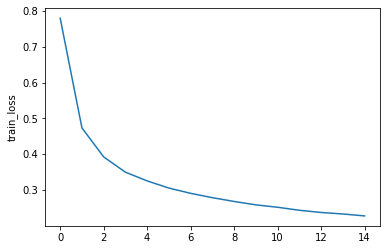

In [10]:
plt.figure()
plt.plot(range(len(loss_train)), loss_train)
plt.ylabel('train_loss')
plt.show()

In [11]:
def test_img(net_g, datatest):
    net_g.eval()
    # testing
    test_loss = 0
    correct = 0
    data_loader = DataLoader(datatest, batch_size=test_batch_size)
    l = len(data_loader)
    for idx, (data, target) in enumerate(data_loader):
        if gpu_id != -1:
            data, target = data.cuda(), target.cuda()
        log_probs = net_g(data)
        # sum up batch loss
        test_loss += F.cross_entropy(log_probs, target, reduction='sum').item()
        # get the index of the max log-probability
        y_pred = log_probs.data.max(1, keepdim=True)[1]
        correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum()

    test_loss /= len(data_loader.dataset)
    accuracy = 100.00 * correct / len(data_loader.dataset)
    
    return accuracy, test_loss

In [12]:
acc, loss = test_img(global_model, dataset_test)
print(acc)

tensor(90.3500)


Not bad at all! This concludes our little experiment with federated learning! Let me know what you thought of this little snippet, your feedback is soooo valuable to me. Next time, we will turn this code into a Python script and experiment with different values and visualize our results. Stay tuned! 

### Footnotes

[<sup id="fn1">1</sup>](#fn1) Depending on the system configurations, a weighted averaging scheme might be preferred. For example, in many applications of federated learning, the weight of the model update of a user is directly proportional with the local dataset size of the user.
<!--  </span> -->
 
 [<sup id="fn2">2</sup>](#fn2) <span id="fn2"> There are still some privacy issues associated with FL because model updates carry some information about the datasets of the users. However, in comparison to other distributed learning paradigms where data is shared with other parties, FL allows a certain degree of privacy. </span>
 
[<sup id="fn3">3</sup>](#fn3) <span id="fn3"> The distribution of the dataset to users actually impacts the performance of federeated learning quite a bit. We will learn about this more in the upcoming lessons. But for now, for simplicity, we will only work with IID data for the users. Dealing with non-IID data distributions is an open area of research for FL. There are some resources [4, 5, 6] in the references in case you would like to check them out.</span>

[<sup id="fn4">4</sup>](#fn4) <span id="fn4"> There are many use cases where the learning rates of different users might be different, such as [7].</span>

### References 

[1] McMahan, Brendan, et al. "Communication-efficient learning of deep networks from decentralized data." Artificial intelligence and statistics. PMLR, 2017.

[2] Shaoxiong Ji. (2018, March 30). A PyTorch Implementation of Federated Learning. Zenodo.

[3] Xiao, Han, Kashif Rasul, and Roland Vollgraf. "Fashion-mnist: a novel image dataset for benchmarking machine learning algorithms." arXiv preprint arXiv:1708.07747 (2017).

[4] Li, Xiang, et al. "On the convergence of fedavg on non-iid data." arXiv preprint arXiv:1907.02189 (2019).

[5] Karimireddy, Sai Praneeth, et al. "Scaffold: Stochastic controlled averaging for federated learning." International Conference on Machine Learning. PMLR, 2020.

[6] Li, Xiaoxiao, et al. "Fedbn: Federated learning on non-iid features via local batch normalization." arXiv preprint arXiv:2102.07623 (2021).

[7] Xu, Chunmei, et al. "Learning rate optimization for federated learning exploiting over-the-air computation." IEEE Journal on Selected Areas in Communications 39.12 (2021): 3742-3756.